# HW5: Autoencoders

In this homework, we will explore how to develop a simple Autoencoder. As a dataset, we will use the MNIST dataset. It contains handwritten digits images.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset, already used in HW4.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

### Load Dataset
We load the MNIST dataset, using tf.keras.datasets. The dataset contains 60,000 training images and 10,000 testing images.
The value of each pixel is between 0 and 255, and it represents a point of an image of size 28 x 28. We will normalize all values between 0 and 1, and we will flatten the 28x28 images into vectors of size 784.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid = x_train[:10000]
x_train = x_train[10000:]

## Exercise 5.1: Singular Value Decomposition

Principal component analysis (PCA) and singular value decomposition (SVD) are both classical linear dimensionality reduction methods that attempt to find linear combinations of features in the original high dimensional data matrix to construct a meaningful representation of the dataset.
In this first part of the HW, we will focus our attention on SVD decomposition, a numerical stable method. Given a matrix X, the SVD decomposes it into the product of two unitary matrices V and U and a rectangular diagonal matrix of singular values S:

$$ X=V \cdot S \cdot U^T.$$

SVD is already implemented in NumPy as np.linalg.svd. In our case, the X matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features).

Note that, the X matrix in our case will have a huge number of rows (we have 50000 input samples) and only 784 columns. Therefore to optime the memory consumption, we can compute the SVD of the covariance matrix. An interesting property of the SVD is that we compute the decomposition of the covariance matrix $C= X^T \cdot X$, and we will obtain the following decomposition:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix U to compute the compressed version of our data, this method will be very convenient. If you are using the collab free plan, the quantity of available ram is not sufficient to compute the SVD of X, therefore computing the SVD of the covariance matrix turns out to be the best solution. 

In [3]:
def svd_k(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k


Let's define the ENCODING_DIM, that will be the size of the compressed version of input data. And compute the compressed version of the training set and the test set.

What happens varying the ENCODING_DIM? test  and discuss the results in a new cell after the following one.

In [4]:
ENCODING_DIM = 120

U_k=svd_k(x_train, ENCODING_DIM)

x_training_pca = np.dot(x_train, U_k)
x_test_pca = np.dot(x_test, U_k)

Reconstruct the input and check how much information was lost due to the compression, by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [5]:
x_training_reco= np.dot(x_training_pca, U_k.T)
x_test_reco= np.dot(x_test_pca, U_k.T)

In [6]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("training mse: %.5f" % ( accuracy_train))
print("test mse: %.5f" % ( accuracy_test))

training mse: 0.00464
test mse: 0.00455


In [7]:
def plot_img(n, input_data, decoded_imgs):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(input_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Let's check how well the input can be reconstructed by printing a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of shown images corresponds to input data, while the second one contains the reconstructions.

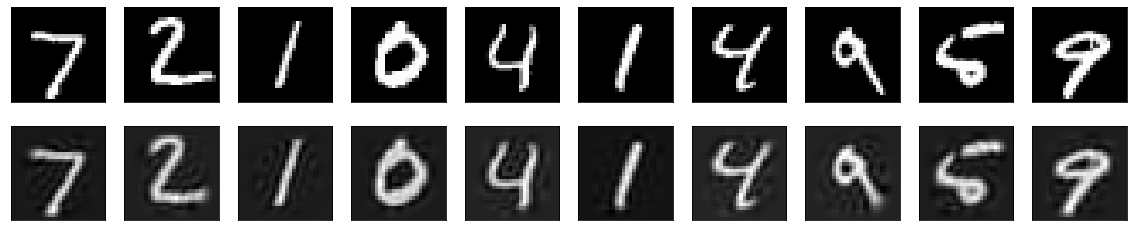

In [8]:
plot_img(10, x_test, x_test_reco)

With encoding dims = 50
training mse: 0.01183
test mse: 0.01150


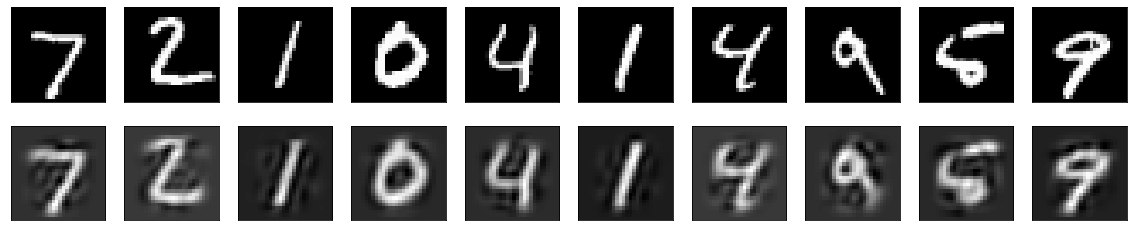

With encoding dims = 250
training mse: 0.00147
test mse: 0.00146


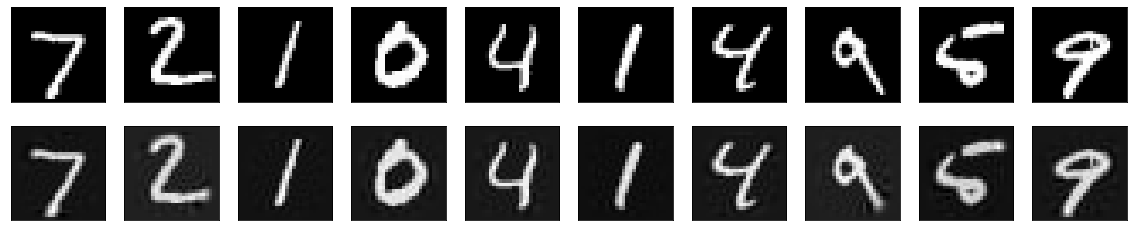

With encoding dims = 500
training mse: 0.00005
test mse: 0.00005


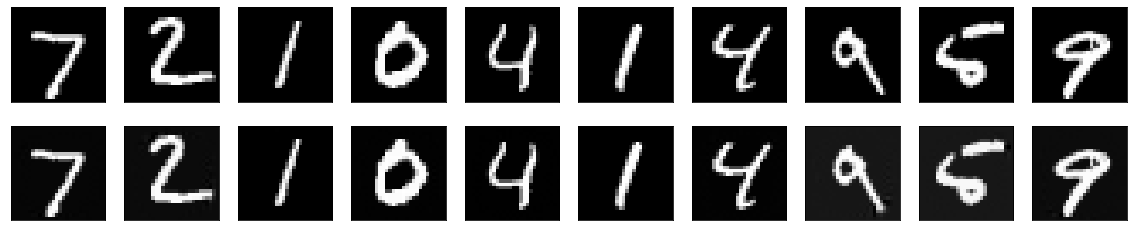

With encoding dims = 784
training mse: 0.00000
test mse: 0.00000


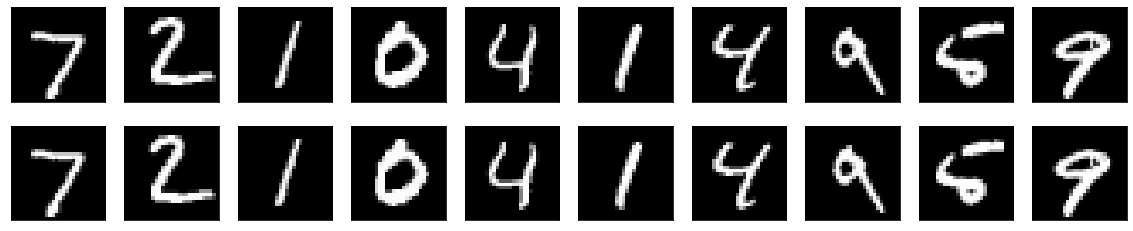

With encoding dims = 1000
training mse: 0.00000
test mse: 0.00000


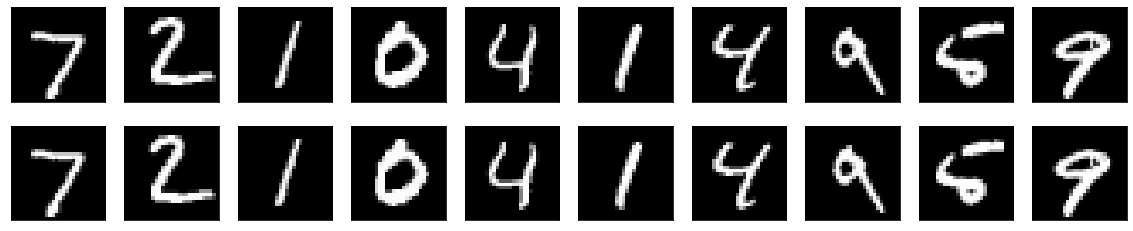

In [14]:
encoding_dims = [50, 250, 500, 784, 1000]
for i in range(len(encoding_dims)):
    U_k = svd_k(x_train, encoding_dims[i])
    
    x_training_pca = np.dot(x_train, U_k)
    x_test_pca = np.dot(x_test, U_k)
    
    x_training_reco= np.dot(x_training_pca, U_k.T)
    x_test_reco= np.dot(x_test_pca, U_k.T)
    
    accuracy_train = ((x_train - x_training_reco)**2).mean()
    accuracy_test = ((x_test - x_test_reco)**2).mean()
    print("With encoding dims = {value}".format(value=encoding_dims[i]))
    print("training mse: %.5f" % ( accuracy_train))
    print("test mse: %.5f" % ( accuracy_test))
    
    plot_img(10, x_test, x_test_reco)
    

### What happens with the reconstructed images?

As we can observe the MSE for both training and testing decreases until the encoding dimension reaches the dimenstion of the flattened images 28x28 = 784. Trying with a higher number on encoding dims does not yield a different result as the entire image is described within the SVD decomposition with encoding_dim >= 784.

## Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous homework, instead of using Keras.Sequential(), we define the various part of the model (encoder and decoder) separately and then we create the final model. 

Check the results and compare them versus the results obtained with the SVD. Add a cell  at the end of this section (after the result of the linear autoencoder) where you give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


In [15]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')


Print the model summary.

In [16]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 120)               94200     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [17]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 6s 45ms/step - loss: 0.0756 - val_loss: 0.0142
Epoch 2/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0120 - val_loss: 0.0084
Epoch 3/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0079 - val_loss: 0.0087
Epoch 4/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0068 - val_loss: 0.0059
Epoch 5/15
98/98 [==============================] - 2s 22ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 6/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 7/15
98/98 [==============================] - 2s 22ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 8/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 9/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 10/15
98/98 [==============================] - 2s 19ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 11/

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [18]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

313/313 - 1s - loss: 0.0058
test mse: 0.00584


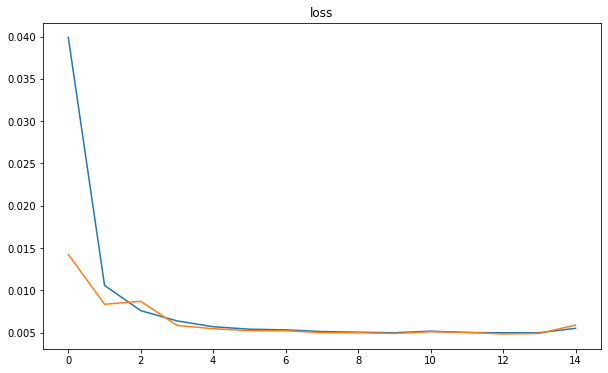

In [19]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

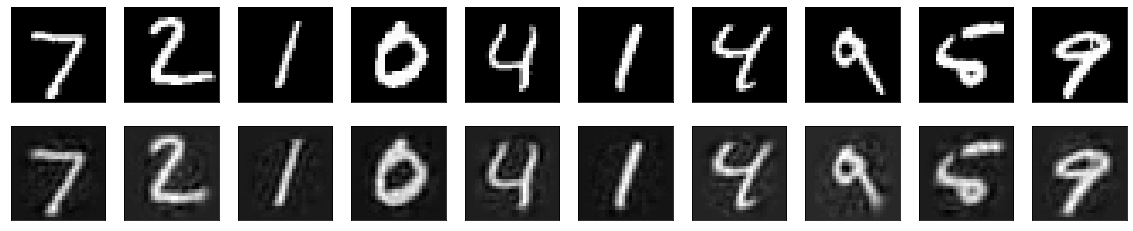

In [20]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                39250     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               39984     
Total params: 79,234
Trainable params: 79,234
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
98/98 [==============================] - 3s 18ms/step - loss: 0.0610 - val_loss: 0.0172
Epoch 2/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0163 - val_loss: 0.0130
Epoch 3/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0129 - val_loss: 0.0123
Epoch 4/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0125 - val_lo

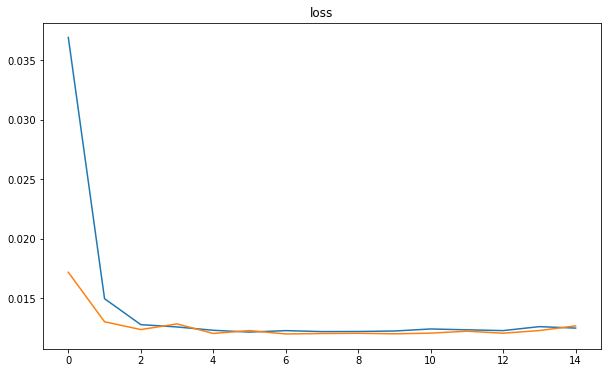

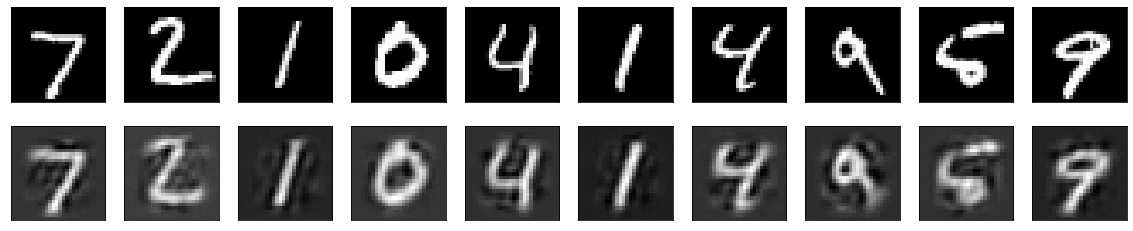

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_7 (Dense)              (None, 784)               615440    
Total params: 1,230,880
Trainable params: 1,230,880
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
98/98 [==============================] - 7s 63ms/step - loss: 2.2432 - val_loss: 0.0489
Epoch 2/15
98/98 [==============================] - 6s 61ms/step - loss: 0.0280 - val_loss: 0.0130
Epoch 3/15
98/98 [==============================] - 6s 60ms/step - loss: 0.0309 - val_loss: 0.0089
Epoch 4/15
98/98 [==============================] - 6s 58ms/step - loss: 0.0205 - 

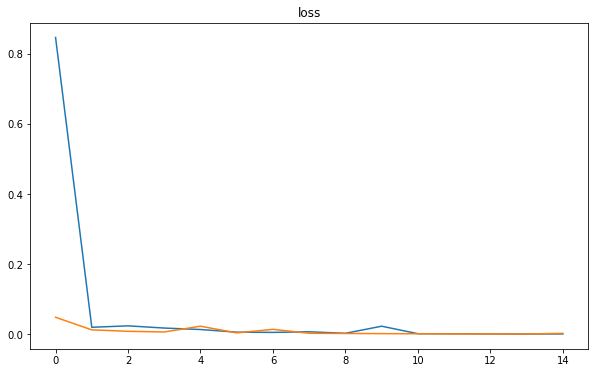

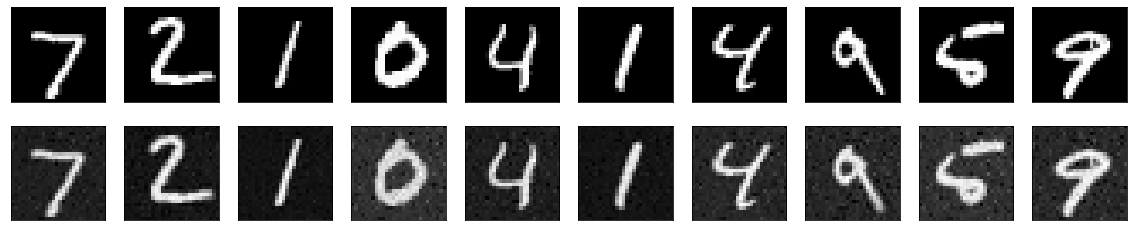

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              785000    
_________________________________________________________________
dense_9 (Dense)              (None, 784)               784784    
Total params: 1,569,784
Trainable params: 1,569,784
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
98/98 [==============================] - 9s 81ms/step - loss: 4.1912 - val_loss: 0.0724
Epoch 2/15
98/98 [==============================] - 8s 78ms/step - loss: 0.0787 - val_loss: 0.0169
Epoch 3/15
98/98 [==============================] - 8s 78ms/step - loss: 0.0154 - val_loss: 0.0119
Epoch 4/15
98/98 [==============================] - 8s 77ms/step - loss: 0.0887 -

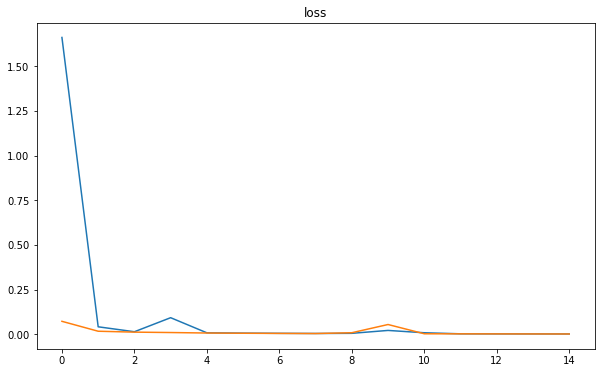

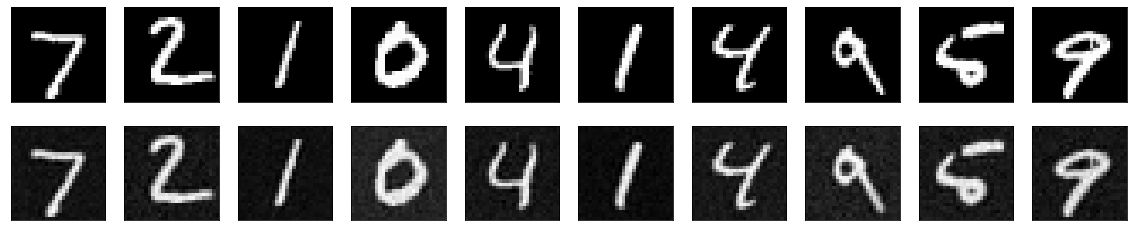

In [22]:
# Test multiple encoding_dims

encoding_dims = [50, 784, 1000]

for i in range(len(encoding_dims)):
    ENCODING_DIM = encoding_dims[i]
    
    
    input_img = tf.keras.layers.Input(shape=(784,))
    #Define the encoder...
    encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)
    
    #...and the decoder...
    decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)
    
    #and finally the autoencoder
    autoencoder = tf.keras.models.Model(input_img, decoded)
    
    # In order to visualize the learned encoding, define a model that computes the 
    # two parts separately.
    encoder = tf.keras.models.Model(input_img, encoded)
    encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
    decoder_layer = autoencoder.layers[-1]
    decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))
    
    #Finally, let's call the compile method
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

    autoencoder.summary()
    
    history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))
    
    plot_loss(history)
    
    scores = autoencoder.evaluate(x_test, x_test, verbose=2)
    print("For encoding_dim = {value}".format(value=ENCODING_DIM))
    print("test mse: %.5f" % (scores))
    
    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)
    
    plot_img(10, x_test, decoded_imgs)

    

### What happens with the shallow linear autoencoder when changing encoding dimension?

The SVD is a more exact way of encoding an image than a shallow linear autoencoder (SLA). Hence the slight accuracy descrepency we observe when looking at the test MSE values for different encoding dimensions. The shallow linear autoencoder performs almost as well as the SVD for a low encoding dimensionality, 50. This probably stems from the SVD missing info that the autoencoder learns through the training phase. When the encoding dimension approaches the dimension of the image we observe that the SVD outperforms the autoencoder. This makes sense as the entire image is loaded into memory through the SVD while the autoencoder has to learn the features.

* Encoding dim = 50
    * SVD test mse: 0.01150
    * SLA test mse: 0.01245

* Encoding dim = 120
    * SVD test mse: 0.00455
    * SLA test mse: 0.00584

* Encoding dim = 784
    * SVD test mse: 0
    * SLA test mse: 0.00315

* Encoding dim = 1000
    * SVD test mse: 0
    * SLA test mse: 0.00156



## Exercise 5.3: Shallow non-linear autoencoders

Replicate the code of Exercise 5.2 but in this case, instead of using linear activation functions use  non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.2. (Insert your code and  theoretical discussion into  cells immediately below this one.)


Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_19 (Dense)             (None, 120)               94200     
_________________________________________________________________
dense_20 (Dense)             (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
98/98 [==============================] - 4s 25ms/step - loss: 0.0688 - val_loss: 0.0166
Epoch 2/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0149 - val_loss: 0.0114
Epoch 3/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0108 - val_loss: 0.0094
Epoch 4/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0092 - val

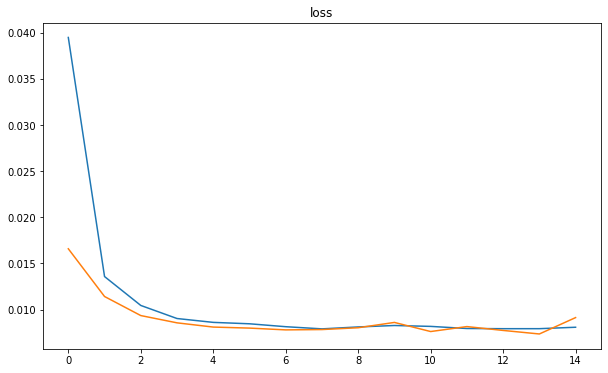

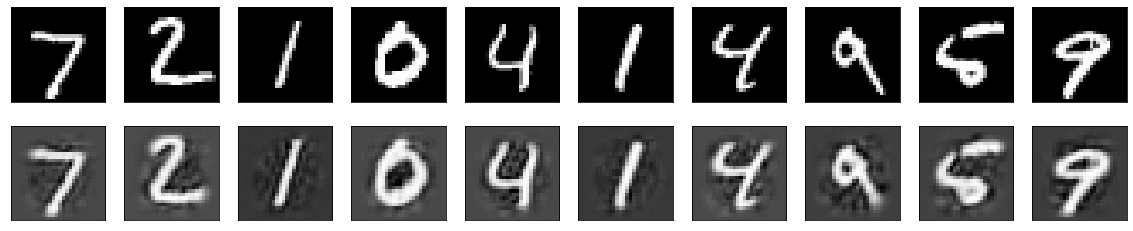

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_21 (Dense)             (None, 120)               94200     
_________________________________________________________________
dense_22 (Dense)             (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
98/98 [==============================] - 4s 24ms/step - loss: 0.0757 - val_loss: 0.0360
Epoch 2/15
98/98 [==============================] - 2s 22ms/step - loss: 0.0324 - val_loss: 0.0234
Epoch 3/15
98/98 [==============================] - 2s 23ms/step - loss: 0.0219 - val_loss: 0.0172
Epoch 4/15
98/98 [==============================] - 2s 22ms/step - loss: 0.0162 - val

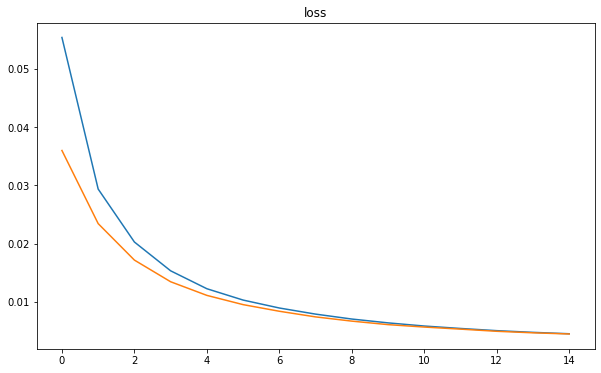

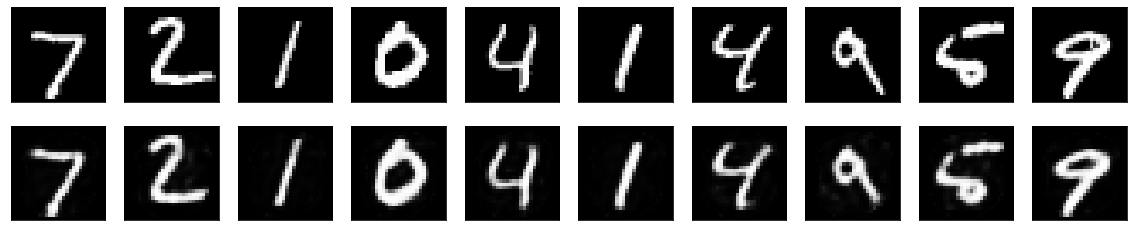

Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_23 (Dense)             (None, 120)               94200     
_________________________________________________________________
dense_24 (Dense)             (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
98/98 [==============================] - 4s 26ms/step - loss: 0.0464 - val_loss: 0.0148
Epoch 2/15
98/98 [==============================] - 2s 21ms/step - loss: 0.0140 - val_loss: 0.0132
Epoch 3/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0128 - val_loss: 0.0123
Epoch 4/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0123 - val

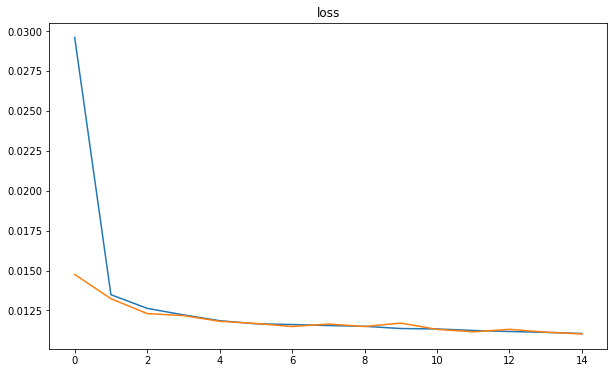

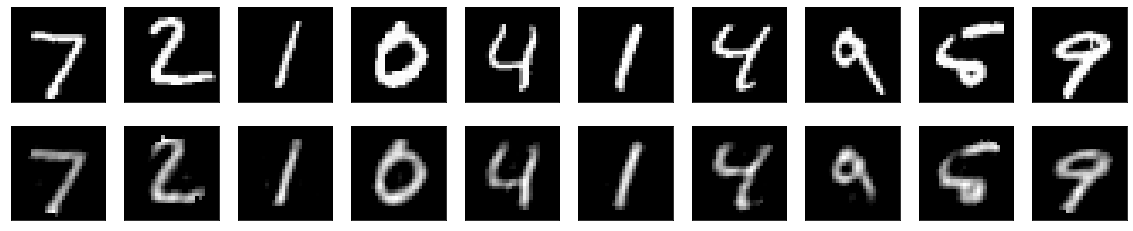

In [26]:
# Test multiple non linear activations

# Non linear autoencoder

ENCODING_DIM = 120
activations = ['tanh', 'sigmoid', 'relu']

for i in range(len(activations)):
    activation = activations[i]
    
    input_img = tf.keras.layers.Input(shape=(784,))
    #Define the encoder...
    encoded = tf.keras.layers.Dense(ENCODING_DIM, activation=activation)(input_img)
    
    #...and the decoder...
    decoded = tf.keras.layers.Dense(784, activation=activation)(encoded)
    
    #and finally the autoencoder
    autoencoder = tf.keras.models.Model(input_img, decoded)
    
    # In order to visualize the learned encoding, define a model that computes the 
    # two parts separately.
    encoder = tf.keras.models.Model(input_img, encoded)
    encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
    decoder_layer = autoencoder.layers[-1]
    decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))
    
    #Finally, let's call the compile method
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

    autoencoder.summary()
    
    history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))
    
    plot_loss(history)
    
    scores = autoencoder.evaluate(x_test, x_test, verbose=2)
    print("For activation function: {function}".format(function=activation))
    print("test mse: %.5f" % (scores))
    
    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)
    
    plot_img(10, x_test, decoded_imgs)

    

### Different non linear activations used with the autoencoder

Here, we tested with encoding dimension 120. The results was as following:

* Linear:
    * SVD test mse: 0.00455
    * Shallow linear autoencoder test mse: 0.00584
* Non linear autoencoders: 
    * Tanh test mse: 0.00901
    * Sigmoid est mse: 0.00440
    * ReLU test mse: 0.01077
    
As we observe from the results, the non linear activation that worked the best was sigmoid activation. Hence the result generalized well to a saturated output between 0 and 1. We can also observe that the learning curve is much smoother when using the sigmoid activation, which perhaps can suggest that the pace at which the autoencoder learns the features, generalizes well for this partcular dataset. 

## Exercise 5.4: Deep Autoencoder
Define a deep version of the Autoeancoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and n-1 for decoding. The layers sizes of the encoding part decrease at each layer (i.e. 784->128->64, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e 128->784, the resulting overall structure recalls an hourglass).
Similarly than what we did above, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [37]:
ENCODING_DIM = 64
activations = ['linear', 'tanh', 'sigmoid', 'relu'] #trying with different combinations of these


input_img = tf.keras.layers.Input(shape=(784,))
encoded1 = tf.keras.layers.Dense(128, activation='sigmoid')(input_img)
encoded2 = tf.keras.layers.Dense(ENCODING_DIM, activation='tanh')(encoded1)
decoded1 = tf.keras.layers.Dense(128, activation='relu')(encoded2)
decoded2 = tf.keras.layers.Dense(784, activation='sigmoid')(decoded1)

autoencoder = tf.keras.models.Model(input_img, decoded2)


autoencoder.compile(optimizer='adam', loss='mse')

In [38]:
autoencoder.summary()

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_34 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_35 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_36 (Dense)             (None, 784)               101136    
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________


In [39]:
history = autoencoder.fit(x_train, x_train, epochs=10, batch_size=32, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.0614 - val_loss: 0.0193
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0172 - val_loss: 0.0131
Epoch 3/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0124 - val_loss: 0.0104
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0100 - val_loss: 0.0089
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0085 - val_loss: 0.0078
Epoch 6/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0076 - val_loss: 0.0070
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0068 - val_loss: 0.0065
Epoch 8/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 9/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 10/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.005

313/313 - 1s - loss: 0.0054
test mse: 0.00539


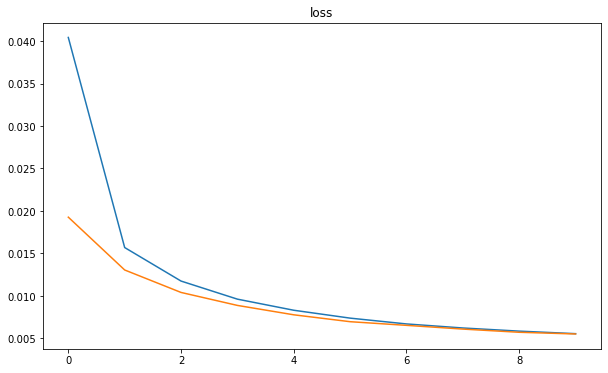

In [40]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

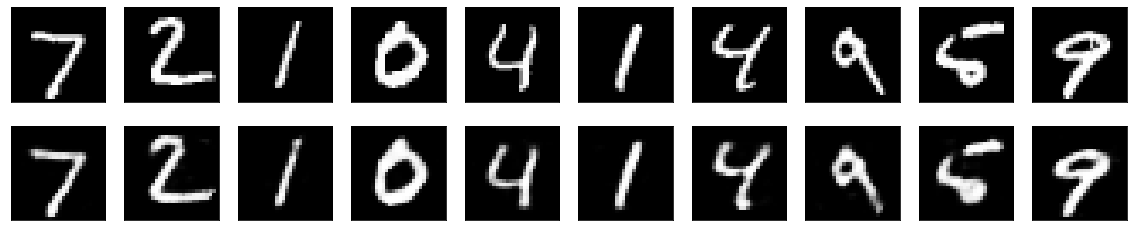

In [41]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, x_test, decoded_imgs)


## Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data.
Firstly, define a noisy input by adding some noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.
**NOTE: in the code at the bottom noise_factor is added and not multiplied for numerical reasons. You may want to try the version with multiplication to verify it is more unstable.**

In [42]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)


x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs.

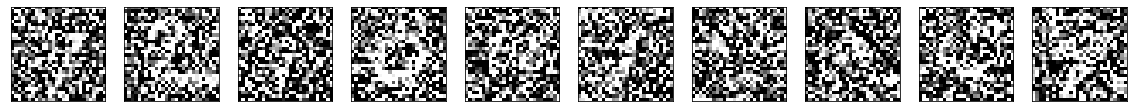

In [43]:
# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Define a shallow autoencoder able to compute a de-noised version of the input (obtained by unsing a noise_factor >= 0.3). 

In [62]:
input_img = tf.keras.layers.Input(shape=(784,))
#encoded1 = tf.keras.layers.Dense(256, activation='sigmoid')(input_img)
encoded2 = tf.keras.layers.Dense(128, activation='linear')(input_img)
#decoded1 = tf.keras.layers.Dense(256, activation='sigmoid')(encoded2)
decoded2 = tf.keras.layers.Dense(784, activation='linear')(encoded2)

autoencoder = tf.keras.models.Model(input_img, decoded2)

autoencoder.compile(optimizer='adam', loss='mse')

In [63]:
autoencoder.summary()

Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_51 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_52 (Dense)             (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________


Train the model by passing the noisy input and the clean target.

In [64]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=15, batch_size=32, shuffle=True, validation_data=(x_valid_noisy, x_valid))

Epoch 1/15
1563/1563 [==============================] - 8s 4ms/step - loss: 0.0701 - val_loss: 0.0415
Epoch 2/15
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0415 - val_loss: 0.0409
Epoch 3/15
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0409 - val_loss: 0.0404
Epoch 4/15
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0407 - val_loss: 0.0406
Epoch 5/15
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0405 - val_loss: 0.0405
Epoch 6/15
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0404 - val_loss: 0.0404
Epoch 7/15
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0404 - val_loss: 0.0405
Epoch 8/15
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0401 - val_loss: 0.0405
Epoch 9/15
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0401 - val_loss: 0.0401
Epoch 10/15
1563/1563 [==============================] - 6s 4ms/step - loss: 0.040

313/313 - 1s - loss: 0.0398
test mse: 0.03982


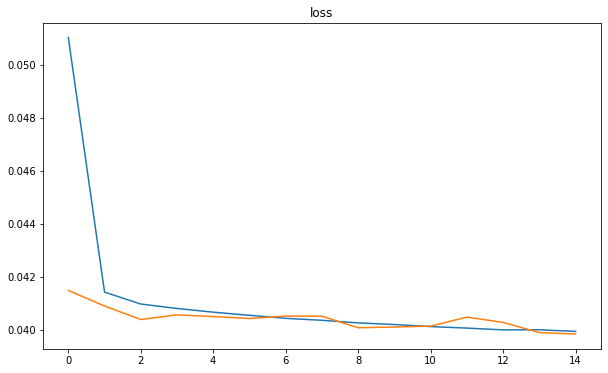

In [65]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores))

Check the result by plotting some input images and the corresponding denoised outputs.

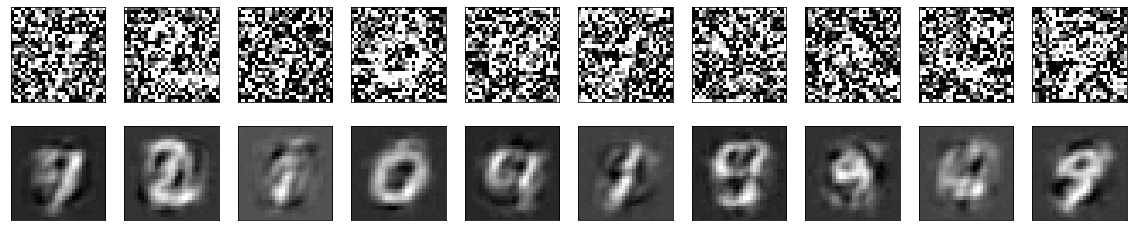

In [66]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, x_test_noisy, decoded_imgs)

### Shallow vs deeper autoencoder for denoising

Here I experimented with 3 different models. 2 shallow models - one linear and one non linear autoencoder - and 1 deeper model. These were the results:
* Deeper model - test mse: 0.03362 with 10 epochs training, activation=sigmoid.
* Shallow model - test mse: 0.03532 with 15 epochs training, activation=sigmoid.
* Shallow model - test mse: 0.03982 with 15 epochs training, activation=linear.

These models performed rather similarly when judging from the MSE on the test set. However there was a huge diffence to the naked eye when judging the images printed above. Judging from the images above it is hard to determine the different numbers. This is by using the shallow model with linear activation. Using a non linear activation function and a deeper model gave a result that seemed more promising to the human eye.

The deeper non linear model is ran below to illustrate the difference in images visible to the human eye. 

In [67]:
# Deeper non linear autoencoder

input_img = tf.keras.layers.Input(shape=(784,))
encoded1 = tf.keras.layers.Dense(256, activation='sigmoid')(input_img)
encoded2 = tf.keras.layers.Dense(128, activation='sigmoid')(encoded1)
decoded1 = tf.keras.layers.Dense(256, activation='sigmoid')(encoded2)
decoded2 = tf.keras.layers.Dense(784, activation='sigmoid')(decoded1)

autoencoder = tf.keras.models.Model(input_img, decoded2)

autoencoder.compile(optimizer='adam', loss='mse')

In [68]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=15, batch_size=32, shuffle=True, validation_data=(x_valid_noisy, x_valid))

Epoch 1/15
1563/1563 [==============================] - 12s 7ms/step - loss: 0.0694 - val_loss: 0.0551
Epoch 2/15
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0514 - val_loss: 0.0454
Epoch 3/15
1563/1563 [==============================] - 10s 7ms/step - loss: 0.0442 - val_loss: 0.0412
Epoch 4/15
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0401 - val_loss: 0.0389
Epoch 5/15
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0375 - val_loss: 0.0370
Epoch 6/15
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0356 - val_loss: 0.0358
Epoch 7/15
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0339 - val_loss: 0.0350
Epoch 8/15
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0326 - val_loss: 0.0347
Epoch 9/15
1563/1563 [==============================] - 12s 7ms/step - loss: 0.0315 - val_loss: 0.0337
Epoch 10/15
1563/1563 [==============================] - 11s 7ms/step - lo

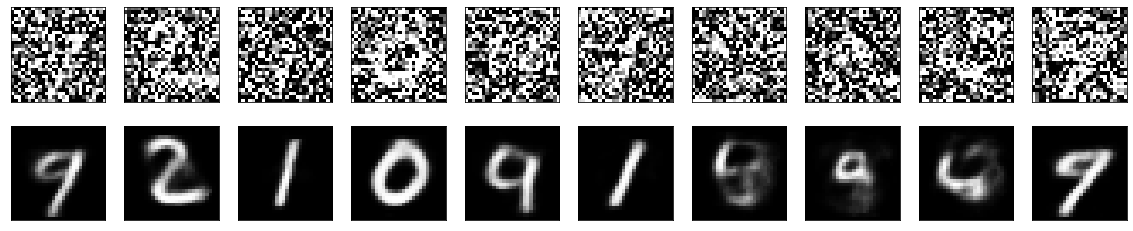

In [69]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, x_test_noisy, decoded_imgs)

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case, as dataset, we will use the IMDB dataset (already presented in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in Colab), we will limit the number of training samples and test samples.

In [70]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])


maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)



<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Anaconda\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Anaconda\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [84]:
X_train_one_hot = keras.utils.to_categorical(X_train_trim)
X_test_one_hot = keras.utils.to_categorical(X_test_trim)
X_valid_one_hot = keras.utils.to_categorical(X_valid_trim)


Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using tf.keras.layers.SimpleRNN. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [85]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 90, 50)            7550      
_________________________________________________________________
time_distributed (TimeDistri (None, 90, 100)           5100      
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [86]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 10s 99ms/step - loss: 0.3983 - categorical_accuracy: 0.0310 - val_loss: 0.1024 - val_categorical_accuracy: 0.2288
Epoch 2/50
79/79 [==============================] - 7s 87ms/step - loss: 0.0880 - categorical_accuracy: 0.3284 - val_loss: 0.0677 - val_categorical_accuracy: 0.4331
Epoch 3/50
79/79 [==============================] - 7s 85ms/step - loss: 0.0642 - categorical_accuracy: 0.4625 - val_loss: 0.0624 - val_categorical_accuracy: 0.4549
Epoch 4/50
79/79 [==============================] - 6s 82ms/step - loss: 0.0587 - categorical_accuracy: 0.4862 - val_loss: 0.0528 - val_categorical_accuracy: 0.5242
Epoch 5/50
79/79 [==============================] - 7s 86ms/step - loss: 0.0608 - categorical_accuracy: 0.4501 - val_loss: 0.0484 - val_categorical_accuracy: 0.5265
Epoch 6/50
79/79 [==============================] - 7s 87ms/step - loss: 0.0456 - categorical_accuracy: 0.5468 - val_loss: 0.0414 - val_categorical_accuracy: 0.5807
Epoch 7/5

79/79 [==============================] - 7s 90ms/step - loss: 0.0088 - categorical_accuracy: 0.9557 - val_loss: 0.0090 - val_categorical_accuracy: 0.9548
Epoch 50/50
79/79 [==============================] - 7s 86ms/step - loss: 0.0087 - categorical_accuracy: 0.9558 - val_loss: 0.0088 - val_categorical_accuracy: 0.9550


Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 1s - loss: 0.0087 - categorical_accuracy: 0.9555
categorical_accuracy: 95.55%


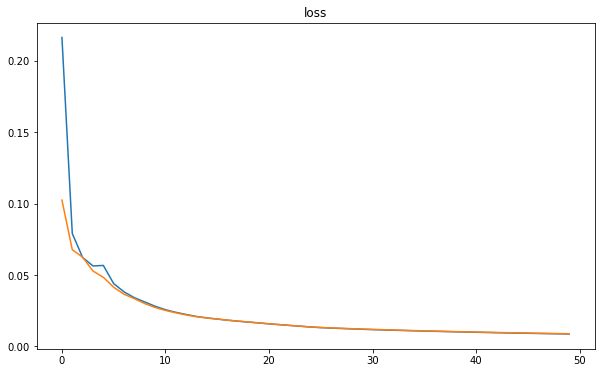

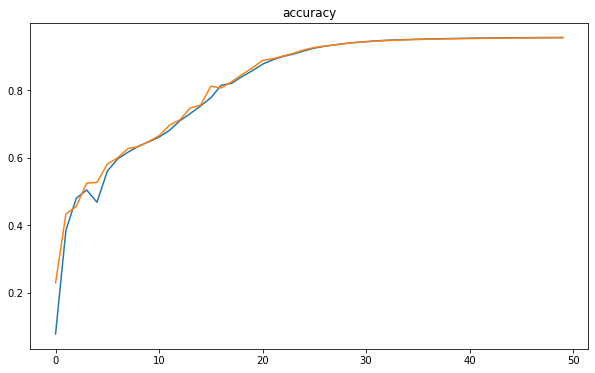

In [87]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [88]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
there a <oov> <oov> that are <oov> in all of that time way that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some at <oov> have <oov> out it <oov> have <oov> <oov> of the film are <oov> <oov> there <oov> is <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really also film that <oov> <oov> <oov> for what <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


## Exercise 5.7: Non-Linear Autoencoder for sequences
Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

In [118]:
lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)

inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, return_sequences=True, activation=lrelu)(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='sigmoid'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 90, 50)            30200     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 90, 100)           5100      
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________


In [119]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 22s 224ms/step - loss: 0.6169 - categorical_accuracy: 0.3693 - val_loss: 0.1954 - val_categorical_accuracy: 0.4615
Epoch 2/50
79/79 [==============================] - 16s 209ms/step - loss: 0.1873 - categorical_accuracy: 0.3426 - val_loss: 0.1817 - val_categorical_accuracy: 0.1208
Epoch 3/50
79/79 [==============================] - 15s 193ms/step - loss: 0.1801 - categorical_accuracy: 0.1239 - val_loss: 0.1813 - val_categorical_accuracy: 0.4614
Epoch 4/50
79/79 [==============================] - 17s 221ms/step - loss: 0.1749 - categorical_accuracy: 0.3058 - val_loss: 0.1700 - val_categorical_accuracy: 0.1354
Epoch 5/50
79/79 [==============================] - 16s 209ms/step - loss: 0.1700 - categorical_accuracy: 0.2557 - val_loss: 0.1761 - val_categorical_accuracy: 0.4657
Epoch 6/50
79/79 [==============================] - 16s 198ms/step - loss: 0.1729 - categorical_accuracy: 0.4758 - val_loss: 0.1723 - val_categorical_accuracy: 0.471

Epoch 50/50
79/79 [==============================] - 9s 115ms/step - loss: 0.0037 - categorical_accuracy: 0.9797 - val_loss: 0.0035 - val_categorical_accuracy: 0.9805


40/40 - 1s - loss: 0.0034 - categorical_accuracy: 0.9816
categorical_accuracy: 98.16%


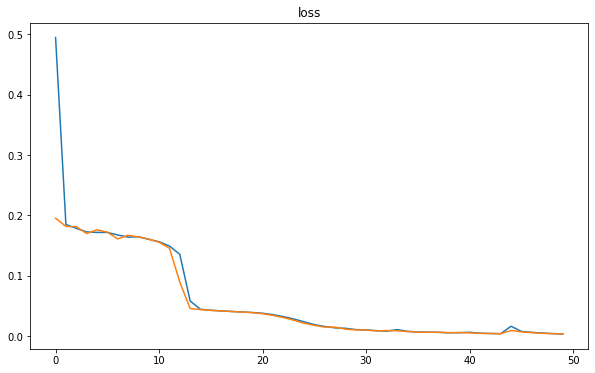

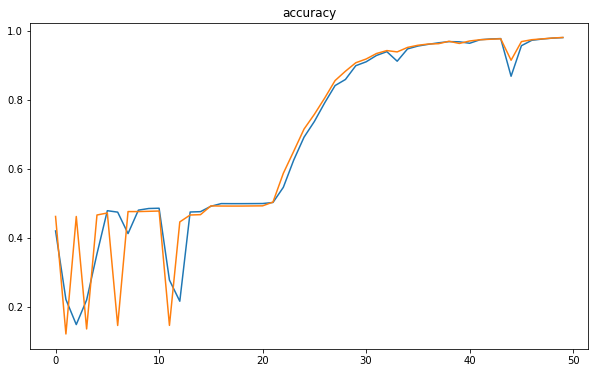

In [120]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [121]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
<oov> <oov> <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


### Results when using a non linear autoencoder

Results:
* Trying the model with sigmoid activation on the LSTM with linear output did not work particularly well as the accuracy was roughly 55%. This is considerebly less than the previously used linear autoencoder used for the same sequence. 

* Adding a sigmoid to the output layer gives a substantial performance increase, pushing the accuracy up to almost 94%.

* Next, trying the LSTM with ReLU activation deemed better. Here, I also added sigmoid activation on the output. The result a bit better, achieving 95% accuracy.

* This made me believe that the ELU activation function may work as well. Hence I switched out ReLU with ELU giving even better accuracy, at 98,5%. The next time I tried the same the accurcay plummeted after roughly 25 epochs, going from 97,2% down to 5% in one epoch before slowly increasing again. I find this wierd and really have no solution to why that happened. 

* Finally I decided to test with Leaky ReLU. The results here were pretty similar to the first iteration of ELU where the accuracy on the test set came out as 98,2%.

It is clear from these results that a non linear activation function on the dense layer greatly improves the accuracy of the network. This activation is also well suited as the sigmoid function as the output is in the interval [0,1]. Trying to use a ReLU or tanh activation here resulted in a worse result. 

When is comes to the activation of the LSTM it seems rather flexible. We observe that the ReLU performs slightly better than with sigmoid, while the ELU and Leaky ReLU perferms even better. This may be the outcome of the data being less saturated for the latter activations. Also, with the sigmoid, the LSTM hidden neurons are more saturated. 